# KTH Trajectory Generation Summaries

## 1. AP Mappings Generation

### 1.1. Generate AP to Index Mappings

In [2]:
import pandas as pd

def generate_mapping(input_path, output_path):
    df = pd.read_csv(input_path)
    unique_aps = pd.unique(df['AP'])
    mapping = {ap: i+1 for i, ap in enumerate(unique_aps)}
    
    # Write the mapping to a .txt file
    with open(output_path, 'w') as file:
        file.write(f'AP,Index\n')
        for ap, index in mapping.items():
            file.write(f'{ap},{index}\n')

In [3]:
# Example Code:
input_path = '/local/traceset1/APlocations.txt'
output_path = '/home/xli5/KTH-traces/KTH_data/AP_to_index.txt'
generate_mapping(input_path, output_path)

### 1.2. Generate AP to Building Index Mappings

In [5]:
import pandas as pd
import re

def generate_building_mapping(input_path, output_path):
    df = pd.read_csv(input_path)
    df['AP'] = df['AP'].str.strip()
    
    def extract_building_number(ap):
        match = re.search(r'Bldg(\d+)', ap)
        if match:
            return int(match.group(1))
        else:
            return None
            
    df['BuildingIndex'] = df['AP'].apply(extract_building_number)
        
    df_to_write = df[['AP', 'BuildingIndex']]
    df_to_write.to_csv(output_path, sep=',', index=False)

In [6]:
# Example Code:
input_path = '/local/traceset1/APlocations.txt'
output_path = '/home/zyuan1/KTH-traces/KTH_data/AP_to_building.txt'
generate_building_mapping(input_path, output_path)

### 1.3. Import Mappings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read in mappings:
ap_to_building = pd.read_csv("/home/zyuan1/research/KTH-traces/KTH_data/AP_to_building.txt", sep = ',', skiprows=1, names=['AP', 'Index'])
ap_to_index = pd.read_csv("/home/zyuan1/research/KTH-traces/KTH_data/AP_to_index.txt", sep = ',', skiprows=1, names=['AP', 'Index'], engine='python')
ap_to_building['AP'] = ap_to_building['AP'].str.strip()
ap_to_index['AP'] = ap_to_index['AP'].str.strip()

## 2. Trajectory Generations

### 2.1. Convert .csv to .dat trajectories
* Inputs:
    * input_path: specify month
    * output_path: where to write the file
    * mapping: a dataframe that maps AP to indices (with or without building agglomeration); contains two columns: AP, and Index
    * start: start time
    * end: end time
* Output:
    * output_path.dat file comprised of trajectories sequences, one per line

In [2]:
def generate_traj(input_path, output_path, mapping, start, end):
    df = pd.read_csv(input_path)
    df = pd.merge(df, mapping, on = 'AP', how = 'left')
    df = df.dropna(subset=['AP'])
    df['Index'] = df['Index'].astype(int)
    df['timestamp'] = pd.to_datetime(df['timestamp'].copy())
    start1 = pd.to_datetime(start)
    end1 = pd.to_datetime(end)
    mask = (start1 < df['timestamp']) & (df['timestamp'] < end1)
    df = df.loc[mask]
    df_grouped = df.groupby('client')['Index'].apply(lambda x: ' '.join(map(str, x)))
    df_grouped = df_grouped.reset_index()
    df_grouped = df_grouped.rename(columns={'Index': 'Seq'})
    # df_grouped.to_csv(f'./data/kth_data/{start}.csv', index=False)
    with open(f'{output_path}.dat', 'w') as file:
        for index in df_grouped['Seq']:
            file.write(index + '\n')

### 2.2. Convert .csv to .dat trajectories; Removed repetitive APs
* Inputs:
    * input_path: specify month
    * output_path: where to write the file
    * mapping: a dataframe that maps AP to indices (with or without building agglomeration); contains two columns: AP, and Index
    * start: start time
    * end: end time
* Output:
    * output_path.dat file comprised of trajectories sequences, one per line

In [3]:
def generate_traj_r(input_path, output_path, mapping, start, end):
    df = pd.read_csv(input_path)
    df = pd.merge(df, mapping, on = 'AP', how = 'left')
    df = df.dropna(subset=['AP'])
    df['Index'] = df['Index'].astype(int)
    df['timestamp'] = pd.to_datetime(df['timestamp'].copy())
    start1 = pd.to_datetime(start)
    end1 = pd.to_datetime(end)
    mask = (start1 < df['timestamp']) & (df['timestamp'] < end1)
    df = df.loc[mask]

    # Group by client and iterate over each group
    def process_group(group):
        last_location = None
        reduced_sequence = []
        for location in group:
            if location != last_location:
                reduced_sequence.append(location)
            last_location = location
        return ' '.join(map(str, reduced_sequence))

    df_grouped = df.groupby('client')['Index'].apply(process_group)
    df_grouped = df_grouped.reset_index()
    df_grouped = df_grouped.rename(columns={'Index': 'Seq'})

    # Save only the 'Seq' column as a CSV
    # df_grouped['Seq'].to_csv(f'./data/kth_data/{name}.dat', index=False, header=False)

    with open(f'{output_path}.dat', 'w') as file:
        for index in df_grouped['Seq']:
            file.write(index + '\n')

In [13]:
# Example code:
input_path = "/local/traceset1/2014_09.csv"
output_path = '/home/xli5/KTH-traces/KTH_data/kth_ngram_removed_rep_APs/'
generate_traj_r(input_path, output_path+'09-15-1', ap_to_index, '2014-09-15 00:00:00', '2014-09-15 11:59:59')
generate_traj_r(input_path, output_path+'09-15-2', ap_to_index, '2014-09-15 12:00:00', '2014-09-15 23:59:59')

#### 2.2.2 Convert .csv to .dat trajectories; Removed repetitive APs; dropped trajectories of 1 point
* Inputs:
    * input_path: specify month
    * output_path: where to write the file
    * mapping: a dataframe that maps AP to indices (with or without building agglomeration); contains two columns: AP, and Index
    * start: start time
    * end: end time
* Output:
    * output_path.dat file comprised of trajectories sequences, one per line

In [2]:
def generate_traj_r_2(input_path, output_path, mapping, start, end):
    df = pd.read_csv(input_path)
    df = pd.merge(df, mapping, on = 'AP', how = 'left')
    df = df.dropna(subset=['AP'])
    df['Index'] = df['Index'].astype(int)
    df['timestamp'] = pd.to_datetime(df['timestamp'].copy())
    start1 = pd.to_datetime(start)
    end1 = pd.to_datetime(end)
    mask = (start1 < df['timestamp']) & (df['timestamp'] < end1)
    df = df.loc[mask]

    # Group by client and iterate over each group
    def process_group(group):
        last_location = None
        reduced_sequence = []
        for location in group:
            if location != last_location:
                reduced_sequence.append(location)
            last_location = location
        if len(reduced_sequence) > 1:
          return ' '.join(map(str, reduced_sequence))
        return None

    df_grouped = df.groupby('client')['Index'].apply(process_group)
    df_grouped = df_grouped.dropna()  # Drop groups with None (single location trajectories)
    df_grouped = df_grouped.reset_index()
    df_grouped = df_grouped.rename(columns={'Index': 'Seq'})
    
    with open(f'{output_path}.dat', 'w') as file:
        for index in df_grouped['Seq']:
            file.write(index + '\n')

In [7]:
# Example code:
input_path = "/local/traceset1/2014_12.csv"
output_path = '/home/zyuan1/research/KTH-traces/KTH_data/kth_new/'
generate_traj_r_2(input_path, output_path+'12-08', ap_to_building, '2014-12-08 00:00:00', '2014-12-08 23:59:59')

### 2.3. Find Threshold for Low Counts AP

#### 2.3.1. Histogram plots
* Inputs:
    * an raw trajectory file: one trajectory per line
* Outputs:
    * a histogram 

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_density_actual(filename):
    # Read the .dat file
    with open(filename, 'r') as f:
        lines = f.readlines()

    # Split the lines into individual AP indices and create a DataFrame
    ap_indices = [int(index) for line in lines for index in line.split()]
    data = pd.DataFrame(ap_indices, columns=["AP"])

    # Calculate frequency count
    freq_count = data["AP"].value_counts()

    # Plot the density histogram
    plt.figure(figsize=(10, 6))
    plt.hist(freq_count, density=True, bins=100, alpha=0.75, edgecolor='black')
    
    plt.xlabel("Number of Visits")  # Label x-axis
    plt.ylabel("Density")  # Label y-axis
    plt.title("Density Plot of Number of Visits to Each AP")
    plt.show()

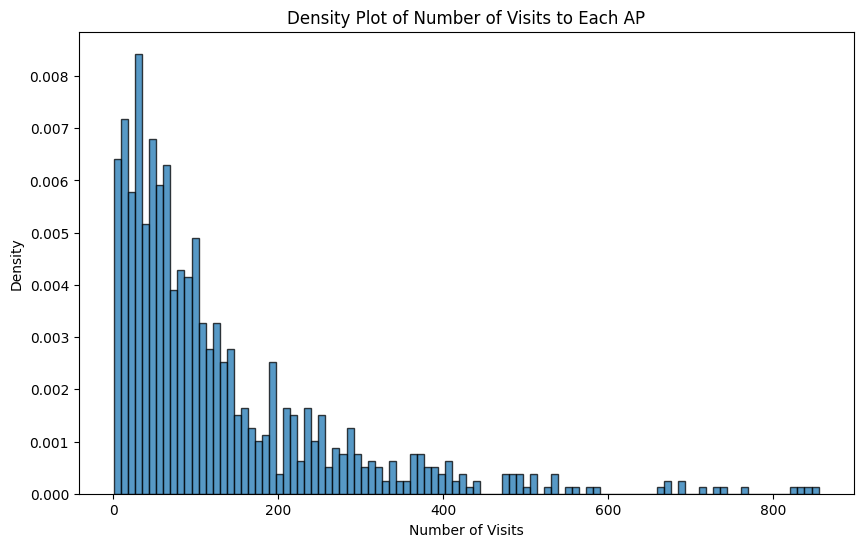

In [11]:
# Example code:
path = '/home/zyuan1/research/KTH-traces/KTH_data/kth_ngram_og_traj/09-15-1.dat'
plot_density_actual(path)

#### 2.3.2. Quantile filter
* Inputs:
    * filename: an raw trajectory file: one trajectory per line
    * x: percentage
* Outputs:
    * a threshold of visits such that x part of the AP visits are below the threshold

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

def calculate_threshold(filename, x):
    # Read the .dat file
    with open(filename, 'r') as f:
        lines = f.readlines()

    # Split the lines into individual AP indices and create a DataFrame
    ap_indices = [int(index) for line in lines for index in line.split()]
    data = pd.DataFrame(ap_indices, columns=["AP"])

    # Calculate frequency count
    freq_count = data["AP"].value_counts()

    # Calculate threshold value
    threshold = freq_count.quantile(x)
    
    return threshold

In [13]:
# Example code:
path = '/home/zyuan1/research/KTH-traces/KTH_data/kth_ngram_og_traj/04-28-1.dat'
threshold = calculate_threshold(path, 0.1)
print(f"The threshold value for the bottom 10% of visits is: {threshold}")
threshold = calculate_threshold(path, 0.2)
print(f"The threshold value for the bottom 20% of visits is: {threshold}")
threshold = calculate_threshold(path, 0.25)
print(f"The threshold value for the bottom 25% of visits is: {threshold}")

The threshold value for the bottom 10% of visits is: 18.0
The threshold value for the bottom 20% of visits is: 35.0
The threshold value for the bottom 25% of visits is: 43.0


### 2.4. Drop Low Counts AP in .cvs and Generate Trajectories

In [8]:
import pandas as pd
def generate_traj_dropped(input_path, output_path, mapping, start, end, threshold):
    df = pd.read_csv(input_path)
    df = pd.merge(df, mapping, on = 'AP', how = 'left')
    df = df.dropna(subset=['AP'])
    df['Index'] = df['Index'].astype(int)
    df['timestamp'] = pd.to_datetime(df['timestamp'].copy())
    start1 = pd.to_datetime(start)
    end1 = pd.to_datetime(end)
    mask = (start1 < df['timestamp']) & (df['timestamp'] < end1)
    df = df.loc[mask]

    # Calculate frequency count of each AP
    freq_count = df['Index'].value_counts().reset_index().rename(columns={"count":"Count"})

    # return freq_count
    # Split into two dataframes: APs to drop and APs to keep
    drop_df = freq_count[freq_count['Count'] < threshold]
    keep_df = freq_count[freq_count['Count'] >= threshold]

    # Remove APs with a count below the threshold
    df = df[df['Index'].isin(keep_df['Index'])]

    df_grouped = df.groupby('client')['Index'].apply(lambda x: ' '.join(map(str, x)))
    df_grouped = df_grouped.reset_index()
    df_grouped = df_grouped.rename(columns={'Index': 'Seq'})
    with open(f'{output_path}.dat', 'w') as file:
        for index in df_grouped['Seq']:
            file.write(index + '\n')

    return drop_df, keep_df

In [ ]:
# Example code:
input_path = "/local/traceset1/2014_12.csv"
output_path = '/home/zyuan1/research/KTH-traces/KTH_data/kth_ngram_dropped_APs/'
day = '12-08'
threshold = 15
drop_df1, keep_df1 = generate_traj_dropped(input_path, f'{output_path}{day}-1-threshold-{threshold}', ap_to_index, f'2014-{day} 00:00:00', f'2014-{day} 11:59:59', threshold)
drop_df2, keep_df2 = generate_traj_dropped(input_path, f'{output_path}{day}-2-threshold-{threshold}', ap_to_index, f'2014-{day} 12:00:00', f'2014-{day} 23:59:59', threshold)

### 2.5. Drop Low Counts AP, Removed Repetitive APs, and Generate Trajectories

In [9]:
import pandas as pd
def generate_traj_dropped_removed(input_path, output_path, mapping, start, end, threshold):
    df = pd.read_csv(input_path)
    df = pd.merge(df, mapping, on = 'AP', how = 'left')
    df = df.dropna(subset=['AP'])
    df['Index'] = df['Index'].astype(int)
    df['timestamp'] = pd.to_datetime(df['timestamp'].copy())
    start1 = pd.to_datetime(start)
    end1 = pd.to_datetime(end)
    mask = (start1 < df['timestamp']) & (df['timestamp'] < end1)
    df = df.loc[mask]

    # Calculate frequency count of each AP
    freq_count = df['Index'].value_counts().reset_index().rename(columns={"count":"Count"})

    # return freq_count
    # Split into two dataframes: APs to drop and APs to keep
    drop_df = freq_count[freq_count['Count'] < threshold]
    keep_df = freq_count[freq_count['Count'] >= threshold]

    # Remove APs with a count below the threshold
    df = df[df['Index'].isin(keep_df['Index'])]

    # Group by client and iterate over each group
    def process_group(group):
        last_location = None
        reduced_sequence = []
        for location in group:
            if location != last_location:
                reduced_sequence.append(location)
            last_location = location
        return ' '.join(map(str, reduced_sequence))

    df_grouped = df.groupby('client')['Index'].apply(process_group)
    df_grouped = df_grouped.reset_index()
    df_grouped = df_grouped.rename(columns={'Index': 'Seq'})
    with open(f'{output_path}.dat', 'w') as file:
        for index in df_grouped['Seq']:
            file.write(index + '\n')

    return drop_df, keep_df

In [ ]:
# Example code:
input_path = "/local/traceset1/2014_12.csv"
output_path = '/home/zyuan1/research/KTH-traces/KTH_data/kth_ngram_dropped_APs_nonrep/'
day = '12-08'
threshold = 15
drop_df1, keep_df1 = generate_traj_dropped_removed(input_path, f'{output_path}{day}-1-threshold-{threshold}', ap_to_index, f'2014-{day} 00:00:00', f'2014-{day} 11:59:59', threshold)
drop_df2, keep_df2 = generate_traj_dropped_removed(input_path, f'{output_path}{day}-2-threshold-{threshold}', ap_to_index, f'2014-{day} 12:00:00', f'2014-{day} 23:59:59', threshold)